In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
ABS_PATH = os.path.abspath("")
IMG_PATH = r"C:\Users\moorb\Documents\MyProjects\Code\SvalbardMap\SvalbardArt\Resized\320_240"
imgs = [plt.imread(os.path.join(IMG_PATH, fname)) for fname in os.listdir(IMG_PATH)]

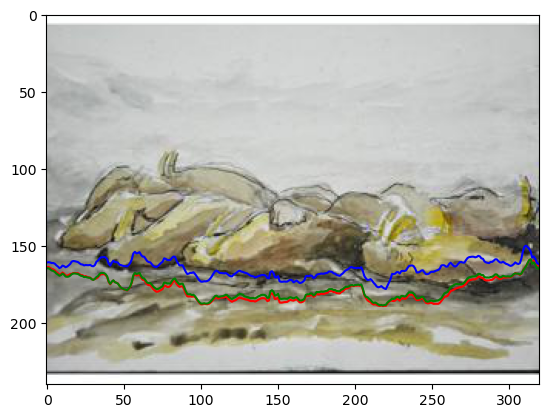

In [5]:
img_color = imgs[-2]
img = img_color[:,:,0]
plt.imshow(img_color)
plt.plot(img_color[:,:,0].mean(axis=0), color="red")
plt.plot(img_color[:,:,1].mean(axis=0), color="green")
plt.plot(img_color[:,:,2].mean(axis=0), color="blue")

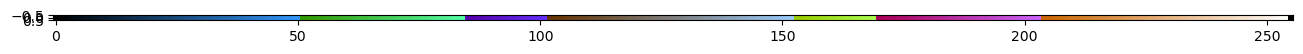

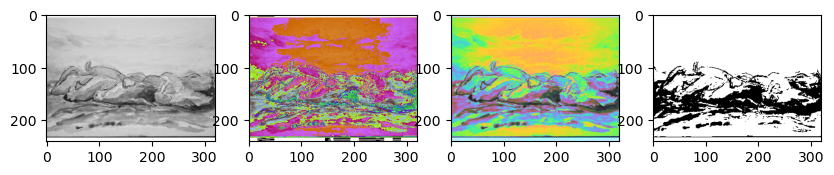

In [64]:
mat = np.array([-0.14861, 1.78277, -0.29227, -0.90649, 1.97294, 0]).reshape(3,2)

def get_cube_helix_colormap(lamb, start_color=0, rotations=-0.01, hue=1/255, gamma=1.):
    lamb = np.array(lamb)
    a = ((hue*lamb**gamma * (1-lamb**gamma))/2)
    phi = 2*np.pi*(start_color/3+rotations*lamb)
    cube_helix_colormap = lamb**gamma + a*mat @ np.array([np.cos(phi), np.sin(phi)])
    return np.clip(cube_helix_colormap, 0, 255).astype("uint8")



def segmentation_pseudocolors(frame):
    cmap = []
    for i in range(256):
        cmap.append([(i*1)%255, (i*3)%255, (i*5)%255])
    cmap = np.array(cmap)
    fig = plt.figure(figsize=(16,6))
    plt.imshow(cmap.reshape(1,-1, 3))
    return cmap[frame]


def cube_helix(frame):
    mapping = [get_cube_helix_colormap(i) for i in range(256)]
    return np.array(mapping)[frame]

def segmentation_hist(frame, n=5):
    hist = np.histogram(frame, range(256))[0]
    hist_diff = hist[1:] - hist[:-1]
    frame = np.where(frame>150, 1, 0)
    return frame


img_pseudo = segmentation_pseudocolors(frame=img)
img_cube = cube_helix(frame=img)
img_hist = segmentation_hist(frame=img)

fig, axes = plt.subplots(1,4, figsize=(10,2))
axes[0].imshow(img, cmap="gray")
axes[1].imshow(img_pseudo)
axes[2].imshow(img_cube)
axes[3].imshow(img_hist, cmap="gray")

In [65]:
from matplotlib.animation import FuncAnimation

def animation(i):
    plt.imshow(cv2.Canny(img, i+150, 255), cmap="gray")

# fig = plt.figure()
# ani = FuncAnimation(fig, animation, frames=50)
# ani.save(os.path.join(ABS_PATH, f"test.gif"))

In [66]:
def local_operator(frame, kernel_size, function):
    
    k, n = kernel_size[0]//2, kernel_size[1]//2
    res_frame = np.zeros_like(frame[k:, n:])
    
    for c in range(frame.shape[2]):
        for i in range(k, frame.shape[0]-k):
            for j in range(n, frame.shape[1]-n):
                curr_frame = frame[i-k:i+1+k,j-n:j+n+1, c]
                res_frame[i-k,j-n, c] = function(curr_frame)
    return res_frame

In [71]:
def entropy(frame):
    '''
    Returns the entropy of a frame (0 to 8).
    '''
    hist, _ = np.histogram(frame, range(256))
    prob = hist/frame.size
    return -(prob * np.log2(prob + 1e-8)).sum()



def huffman_coding(frame):
    '''
    Performs Huffman coding. Iteratively merges least likely gray values until 
    termination condition met. Then, huffman 'code' is calculated and the least 'required memory' 
    according to huffman coding.
    '''
    frame_new = np.array(frame.copy(), dtype=int)
    order = []
    for _ in range(255):
        hist, _ = np.histogram(frame_new, np.arange(257))
        if len(set(hist)) == 2: # break if only visited values last value remain
            break
        hist[hist==0] = frame.size
        min_gray_val = np.argmin(hist)
        hist[hist==np.min(hist)] =  frame.size
        next_min_gray_val = np.argmin(hist)
        frame_new = np.where(frame_new==min_gray_val, next_min_gray_val, frame_new)
        order.append((min_gray_val, next_min_gray_val))

    code = {i: "" for i in range(256)}

    for min_gray_val, next_min_gray_val in reversed(order):
        # print("min", min_gray_val)
        # print("next_min", next_min_gray_val)
        code[min_gray_val] = code[next_min_gray_val] + "0"
        code[next_min_gray_val] = code[next_min_gray_val] + "1"
        # for k, val in code.items(): 
        #     if val=="":
        #         continue
        #     print(k,val)
        # print("\n")
    
    required_memory = 0
    hist, _ = np.histogram(frame, np.arange(257))
    prob = hist/frame.size

    for i, x in enumerate(prob):
        bit_code = code[i]
        # print(bit_code)
        # print(f"{x}")
        required_memory += len(bit_code)*x

    print(f"Entropy: {entropy(frame)}")
    print(f"Required memory: {required_memory}")

    return frame_new, code



huff, code = huffman_coding(frame=img)
# huff = cv2.erode(np.array(huff, dtype="uint8"), np.ones(9).reshape(3,3))
# huff = local_operator(frame=huff.reshape(*img.shape, 1), kernel_size=(3,3), function=lambda x: x.min())
# huff = cv2.filter2D(np.array(huff, dtype="uint8").reshape(*img.shape, 1), kernel=np.ones(25).reshape(5,5)/25, ddepth=-1)
# plt.imshow(huff, cmap="gray")

Entropy: 6.776016337169306
Required memory: 6.838867187499997


In [ ]:
def run_length_encoding(frame):
    encoding = []
    # Get indices where pixel has different gray value than neighbor y-axis.
    frame_diff = frame[:, 1:] - frame[:, :-1]     
    indices_x, indices_y = np.where(frame_diff)
    
    y_old = 0
    x_old = 0
    encoding_row = []


    for x, y in zip(indices_x, indices_y):
        
        n = y-y_old
        # If row changes make new list
        if x!=x_old:
            n = 1
            # Append rest pixels of row as last entry
            encoding_row.append((frame.shape[0]-y, frame[x,y]))
            encoding.append(encoding_row)
            encoding_row = []
        encoding_row.append((n, frame[x,y-1]))
        x_old = x
        y_old = y

    return encoding


run_length_encoding(frame=img)

[[(1, 254),
  (2, 253),
  (2, 252),
  (2, 251),
  (8, 254),
  (32, 255),
  (8, 252),
  (24, 254),
  (16, 253),
  (16, 254),
  (16, 253),
  (8, 254),
  (88, 253),
  (8, 254),
  (8, 253),
  (16, 254),
  (8, 252),
  (8, 254),
  (1, 254),
  (3, 253),
  (4, 254),
  (8, 253),
  (28, 254),
  (3, 253),
  (225, 254)],
 [(1, 254), (32, 255), (237, 254)],
 [(1, 254),
  (12, 253),
  (16, 254),
  (4, 255),
  (4, 254),
  (8, 255),
  (8, 253),
  (24, 254),
  (24, 253),
  (128, 254),
  (8, 253),
  (16, 254),
  (16, 253),
  (3, 252),
  (3, 253),
  (2, 254),
  (8, 253),
  (16, 254),
  (8, 253),
  (239, 252)],
 [(1, 252),
  (6, 251),
  (8, 253),
  (19, 254),
  (5, 253),
  (8, 254),
  (32, 253),
  (16, 252),
  (8, 251),
  (112, 253),
  (8, 252),
  (8, 253),
  (8, 252),
  (24, 253),
  (15, 252),
  (9, 253),
  (16, 254),
  (8, 253),
  (1, 253),
  (4, 252),
  (225, 254)],
 [(1, 254), (32, 255), (238, 251)],
 [(1, 251),
  (4, 252),
  (1, 252),
  (8, 251),
  (20, 252),
  (4, 253),
  (40, 252),
  (16, 253),
  (